In [10]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import sklearn.svm as svm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [11]:
gesture = ["Down", "Up", "Left", "Right"]
path = "HeadData/"
gyro = "/gyro/"
features = 6
trials = 40
x = [[0] * features for i in range(trials * len(gesture))]
y = [0] * trials * len(gesture)

In [12]:
def min_max_feature_order(s1, s2):
    if s1 > s2:
        return 1
    else:
        return 5

In [13]:
for i in range(0, len(gesture), 1):
    for k in range(0, trials, 1):
        path_data = path + gesture[i] + gyro + "trial" + str(k + 1) + ".csv"
        data = genfromtxt(path_data, delimiter=",")
        # Features
        x[k + i * trials][0] = min_max_feature_order(np.argmax(data[:, 1]), np.argmin(data[:, 1]))
        x[k + i * trials][1] = min_max_feature_order(np.argmax(data[:, 3]), np.argmin(data[:, 3]))
        x[k + i * trials][2] = min_max_feature_order(np.argmax(data[:, 2]), np.argmin(data[:, 2]))
        x[k + i * trials][3] = min(data[:, 1])  # down up gestures the x dimension changes the most
        x[k + i * trials][4] = min(data[:, 3])  # right left gestures the z dimension changes the most
        x[k + i * trials][5] = min(data[:, 2])
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        # target variables
        y[[k + i * trials][0]] = i

In [14]:
# Split dataset into training set and test set
# 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [15]:
# Create a svm Classifier
clf = svm.SVC(kernel="linear")  # Linear Kernel

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

Accuracy: 0.925
Precision: 0.925
Recall: 0.925


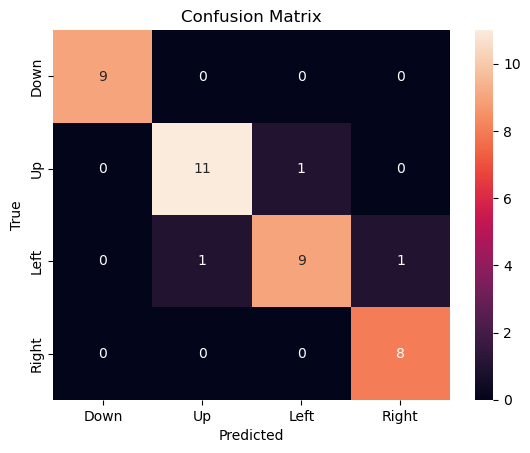

In [16]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred, average="micro"))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred, average="micro"))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

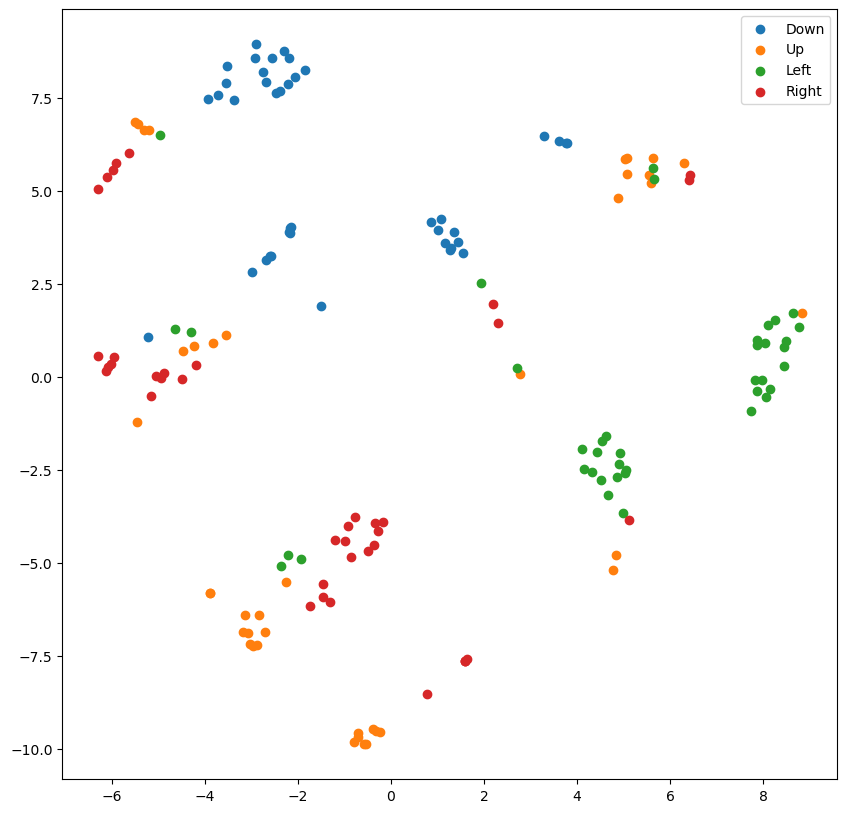

In [17]:
tsne = TSNE(n_components=2)
X_normalized = normalize(np.array(x), axis=0, norm="max")
X_embedded = tsne.fit_transform(X_normalized)
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[np.array(y) == 0, 0], X_embedded[np.array(y) == 0, 1], label=gesture[0])
plt.scatter(X_embedded[np.array(y) == 1, 0], X_embedded[np.array(y) == 1, 1], label=gesture[1])
plt.scatter(X_embedded[np.array(y) == 2, 0], X_embedded[np.array(y) == 2, 1], label=gesture[2])
plt.scatter(X_embedded[np.array(y) == 3, 0], X_embedded[np.array(y) == 3, 1], label=gesture[3])
plt.legend()
plt.show()

Accuracy: 0.9
Precision: 0.9
Recall: 0.9
F1 Score: 0.9


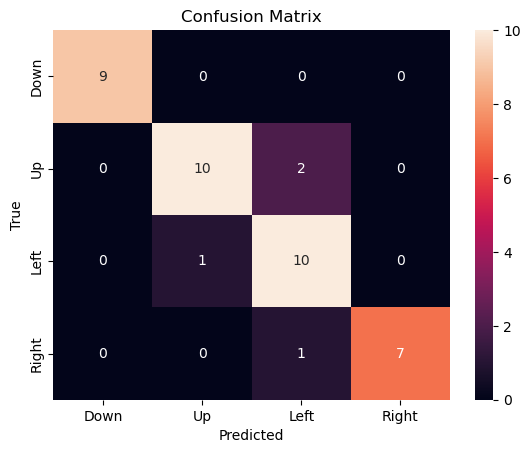

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    return cm, accuracy, precision, recall, f1
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
# test the model
predictions = dtree.predict(X_test)
# Get all the metrics
cm, accuracy, precision, recall, f1 = get_metrics(y_test, predictions)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# Plot the confusion matrix
cm_df = pd.DataFrame(cm, index=gesture, columns=gesture)
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

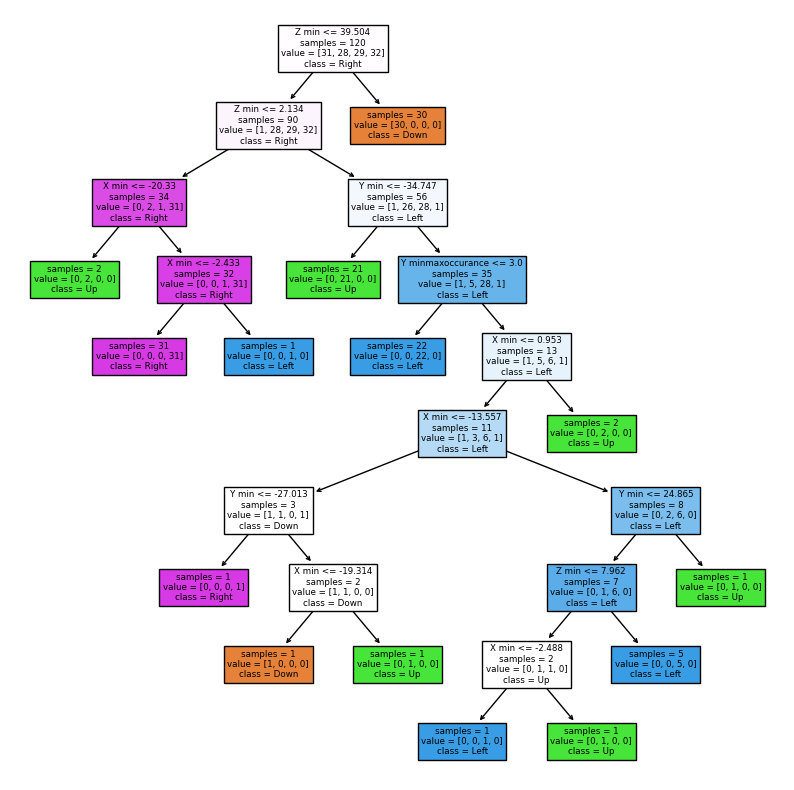

In [19]:
plt.figure(figsize=(10, 10))
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]
target_names = gesture
tree.plot_tree(dtree, filled=True, impurity=False, feature_names=feature_names, class_names=target_names)
plt.show()

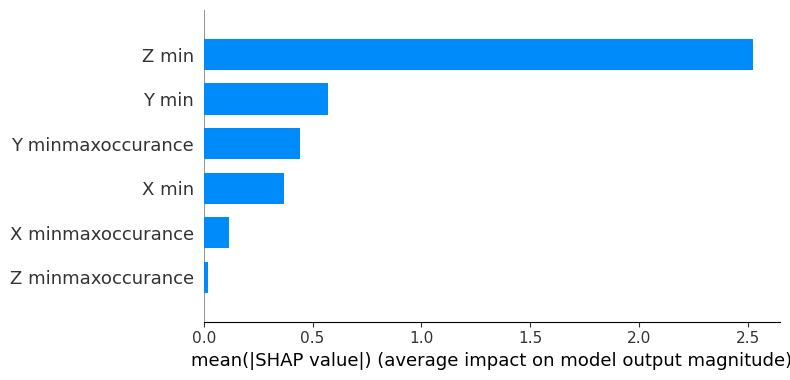

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))

explainer = shap.Explainer(clf, np.array(X_train))
shap_values_individual = explainer.shap_values(np.array(X_test))
shap_values = sum(shap_values_individual) / len(shap_values_individual)
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]
target_names = ["Down", "Up", "Left", "Right"]

shap.summary_plot(shap_values, plot_type="bar", class_names=target_names, feature_names=feature_names)

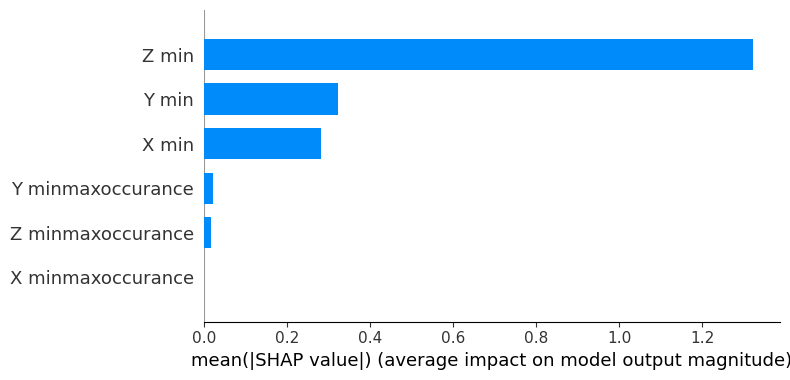

In [ ]:
# gesture = ['Down', 'Up', 'Left', 'Right']
gesture = ["Left", "Right"]
path = "HeadData/"
gyro = "/gyro/"
features = 6
trials = 40
x = [[0] * features for i in range(trials * len(gesture))]
y = [0] * trials * len(gesture)
for i in range(0, len(gesture), 1):
    for k in range(0, trials, 1):
        path_data = path + gesture[i] + gyro + "trial" + str(k + 1) + ".csv"
        data = genfromtxt(path_data, delimiter=",")
        # Features
        x[k + i * trials][0] = min_max_feature_order(np.argmax(data[:, 1]), np.argmin(data[:, 1]))
        x[k + i * trials][1] = min_max_feature_order(np.argmax(data[:, 3]), np.argmin(data[:, 3]))
        x[k + i * trials][2] = min_max_feature_order(np.argmax(data[:, 2]), np.argmin(data[:, 2]))
        x[k + i * trials][3] = min(data[:, 1])  # down up gestures the x dimension changes the most
        x[k + i * trials][4] = min(data[:, 3])  # right left gestures the z dimension changes the most
        x[k + i * trials][5] = min(data[:, 2])
        # x[k+i*trials][4]=max(data[:,1]) # down up gestures the x dimension changes the most
        # x[k+i*trials][5]=max(data[:,3]) # right left gestures the z dimension changes the most
        # x[k+i*trials][6]=data[:,1].mean() # mean for x dimension
        # x[k+i*trials][7]=data[:,3].mean() # mean for z dimension
        # x[k+i*trials][8]=data[:,1].std() # std for x dimension
        # x[k+i*trials][9]=data[:,3].std() # std for z dimension
        # target variables
        y[[k + i * trials][0]] = i
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

clf = svm.SVC(kernel="linear")
clf.fit(np.array(X_train), np.array(y_train))

explainer = shap.Explainer(clf, np.array(X_train))
shap_values_individual = explainer.shap_values(np.array(X_test))
shap_values = sum(shap_values_individual) / len(shap_values_individual)
feature_names = ["X minmaxoccurance", "Z minmaxoccurance", "Y minmaxoccurance", "X min", "Z min", "Y min"]

shap.summary_plot(shap_values.reshape(1, -1), plot_type="bar", feature_names=feature_names)